# Comparing different models for the same dataset
### Imports

In [175]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.optimize import minimize

import package_DBR
from package_DBR import myRound, FOPDT, FOPDT_cost, SOPDT, SOPDT_cost, Process, Bode

### Data Loading

In [176]:
nameFile = 'Cleaned_data_Open_loop_experiment_on_MV_2024-03-11-09h15.txt'

titleName = nameFile.split('.')[0]    
data = pd.read_csv('Data/' + nameFile)

if 'MV' in nameFile:
    ExpVariable = 'MV'
    tm = data['tm'].values
    MVm = data['MVm'].values
    PVm = data['PVm'].values    
else:    
    ExpVariable = 'DV'
    tm = data['tm'].values
    DVm = data['DVm'].values 
    PVm = data['PVm'].values
     
print(ExpVariable)    

MV


## Van der Grinten model data n°1
using computer generated optimisation data.

In [177]:
class Optimization:
    def __init__(self) -> None:
        # Final SSE Objective: 0.013042981315805214
        self.K = 0.35711258020523884
        self.T1 = 140.00376928937064
        self.T2 = 7.922782664796644
        self.theta = 7.3555801756095915
        self.Ts = 1.0
        self.model = 'SOPDT'

    def PVSim(self, MVm, K, T1, T2, theta, Ts):
        return SOPDT(MVm, K, T1, T2, theta, Ts)

## Data gathered manually from the graph

In [178]:
Kp = 0.34
a = 0.11
Tu = 13.33
Tg = 153.34
t1 = 62.22
t2 = 85.16
Ts = 1.0
bn = 1

## Van der Grinten model data n°2
using graph data.

In [179]:
class Grinten:
    def __init__(self) -> None:
        pass

    def calc_T1(self, Tg, a):
        return Tg * ((3*a*math.exp(1) - 1) / (1 + a*math.exp(1)))
    
    def calc_T2(self, Tg, a):
        return Tg * ((1 - a*math.exp(1)) / (1 + a*math.exp(1)))
    
    def calc_theta(self, Tu, T1, T2):
        return Tu - (T1*T2) / (T1 + 3*T2)
    
    def PVSim(self):
        T1 = self.calc_T1(Tg, a)
        T2 = self.calc_T2(Tg, a)
        theta = self.calc_theta(Tu, T1, T2)
        print('Grinten', T1,T2,theta)
        return SOPDT(MVm, Kp, T1, T2, theta, Ts)
    

## Broida method 1 model data

In [180]:
class Broida1:
    def __init__(self) -> None:
        pass

    def PVSim(self):
        print('Broida1',Tg, Tu)
        return FOPDT(MVm, Kp, Tg, Tu, Ts)

    

## Broida method 2 model data

In [181]:
class Broida2:
    def __init__(self) -> None:
        pass

    def calc_T(self, t1, t2):
        return 5.5*(t2 - t1)
    
    def calc_theta(self, t1, t2):
        return (2.8*t1 - 1.8*t2)
    
    def PVSim(self):
        T = self.calc_T(t1, t2)
        theta = self.calc_theta(t1, t2)
        print('Broida2', T, theta)
        return FOPDT(MVm, Kp, T, theta, Ts)
    

## Strejc model data

In [182]:
class Strejc:
    def __init__(self) -> None:
        pass

    def calc_T(self, Tg, bn):
        return Tg/bn
    
    def calc_theta(self, Tu, an, Tg):
        return Tu-an*Tg
    
    def PVSim(self):
        T = self.calc_T(Tg, bn)
        theta = self.calc_theta(Tu, 0, Tg)
        print('Strejc',T, theta)
        return FOPDT(MVm, Kp, T, theta, Ts)
    

## Plot of all the models

Grinten -12.154600112092186 82.7473000560461 17.59012048211734
Broida1 153.34 13.33
Broida2 126.16999999999999 20.92799999999997
Strejc 153.34 13.33


(0.0, 458.0)

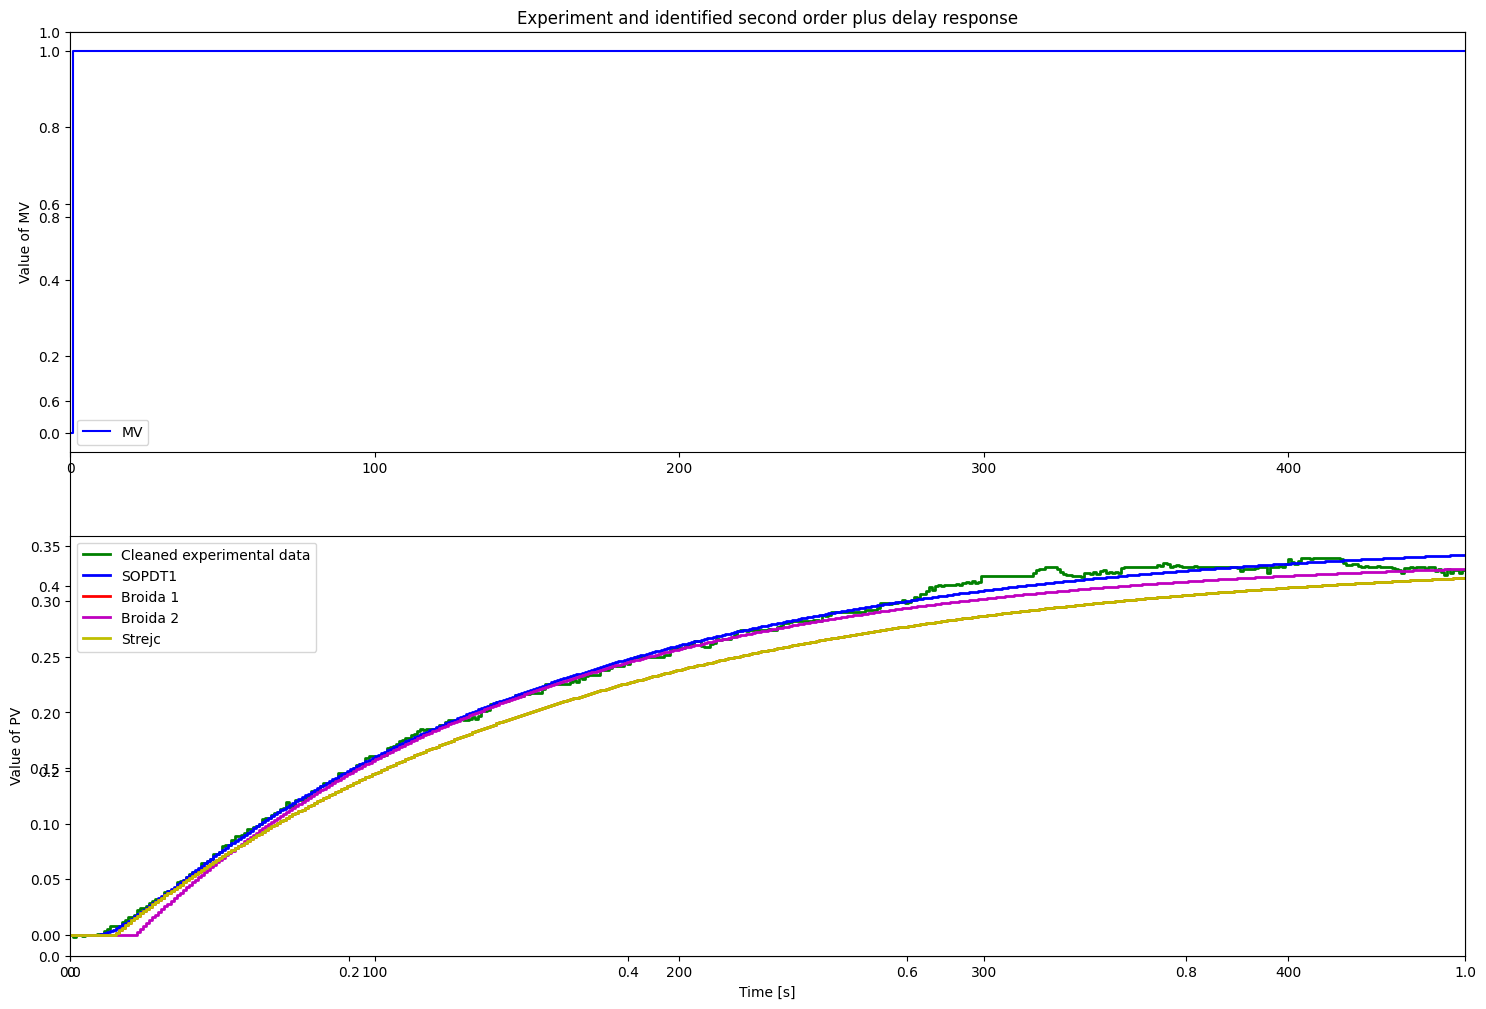

In [183]:
plt.figure(figsize = (18,12))

plt.title('Experiment and identified second order plus delay response')

# Van der Grinten n° 1

opt = Optimization()
PVSim_SOPDT1 = opt.PVSim(MVm, opt.K, opt.T1, opt.T2, opt.theta, opt.Ts)

# Van der Grinten n° 2

grinten = Grinten()
PVSim_Grinten = grinten.PVSim()

# On ne va pas pouvoir utiliser Grinten car T1 est négatif
# TODO: ajouter un bout de code qui vérifie que T1 et T2 sont positifs

# Broida n° 1

broida1 = Broida1()
PVSim_Broida1 = broida1.PVSim()

# Broida n°2

broida2 = Broida2()
PVSim_Broida2 = broida2.PVSim()

# Strejc

strejc = Strejc()
PVSim_Strejc = strejc.PVSim()

plt.subplot(2,1,1)
plt.step(tm,MVm,'b-',label='MV',where='post')
plt.ylabel('Value of MV')
plt.legend(loc='best')
plt.xlim([0, np.max(tm)])   

plt.subplot(2,1,2)
plt.step(tm,PVm,'g-',linewidth=2,label='Cleaned experimental data',where='post')
plt.step(tm,PVSim_SOPDT1,'b-',linewidth=2,label='SOPDT1',where='post')
plt.step(tm,PVSim_Broida1,'r-',linewidth=2,label='Broida 1',where='post')
plt.step(tm,PVSim_Broida2,'m-',linewidth=2,label='Broida 2',where='post')
plt.step(tm,PVSim_Strejc,'y-',linewidth=2,label='Strejc',where='post')
plt.ylabel('Value of PV')
plt.xlabel('Time [s]')
plt.legend(loc='best')
plt.xlim([0, np.max(tm)])


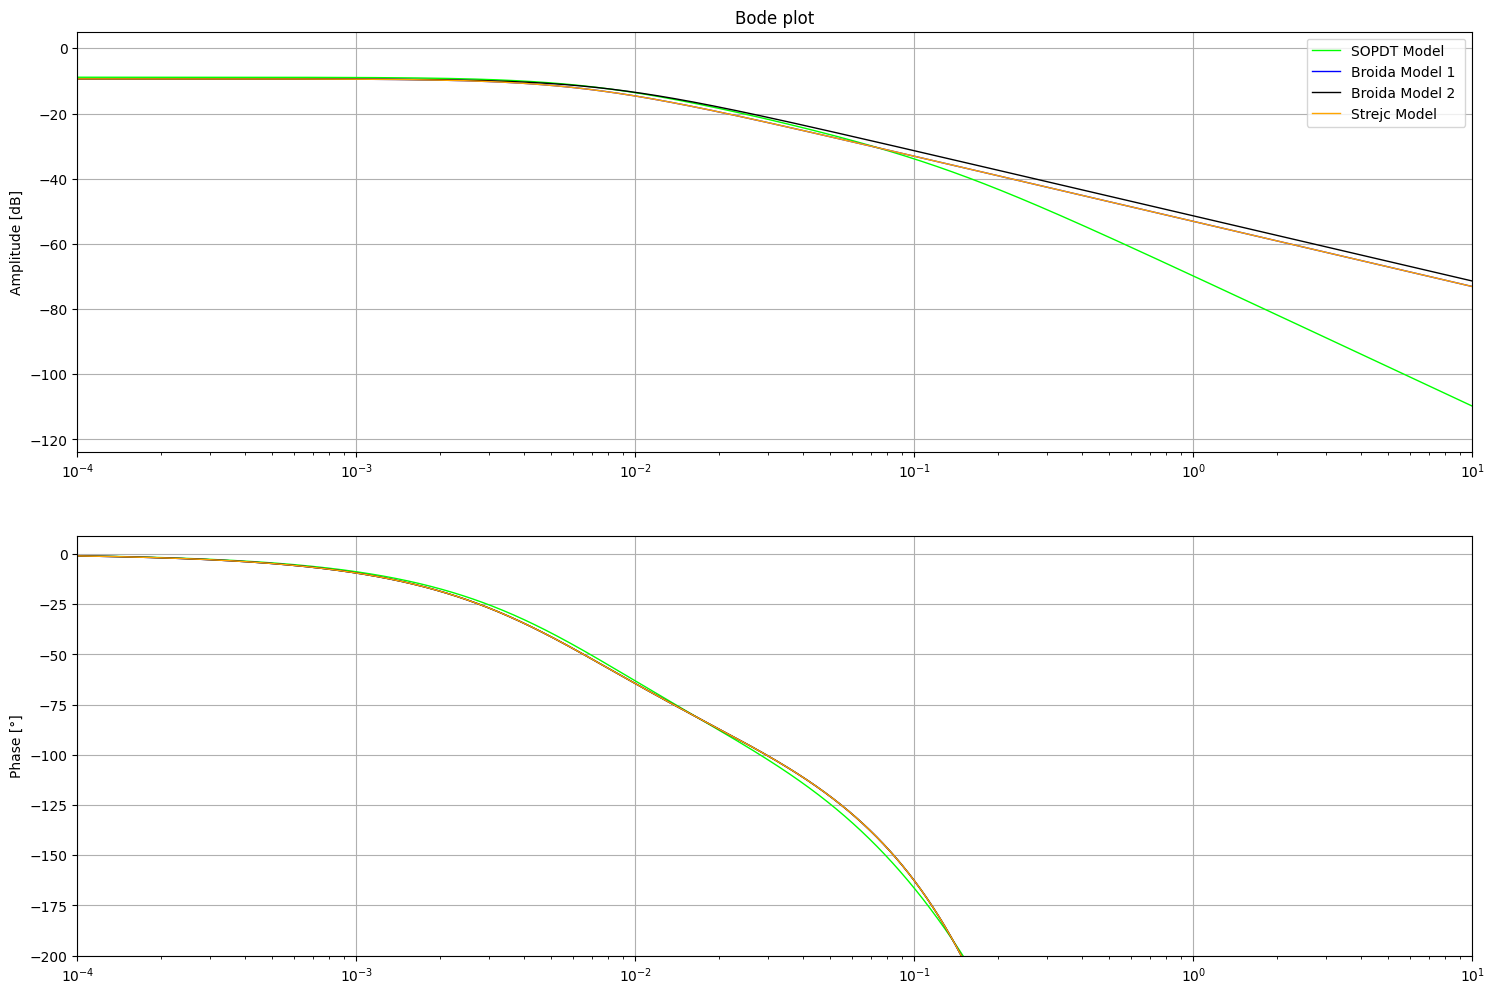

In [184]:
# SOPDT model parameters (from the Optimization)
Kp_SOPDTOPT = 0.36
T1_SOPDTOPT = 140
T2_SOPDTOPT = 7.92
theta_SOPDTOPT = 7.35


P_SOPDTOPT = Process({})
P_SOPDTOPT.parameters['Kp'] = Kp_SOPDTOPT
P_SOPDTOPT.parameters['Tlag1'] = T1_SOPDTOPT
P_SOPDTOPT.parameters['Tlag2'] = T2_SOPDTOPT
P_SOPDTOPT.parameters['theta'] = theta_SOPDTOPT

# Broida 1 model parameters
Kp_Broida1 = 0.34
T_Broida1 = 153.34  
theta_Broida1 = 13.33  

P_BROIDA1 = Process({})
P_BROIDA1.parameters['Kp'] = Kp_Broida1
P_BROIDA1.parameters['Tlag1'] = T_Broida1
P_BROIDA1.parameters['theta'] = theta_Broida1

# Broida 2 model parameters
Kp_Broida2 = 0.34
T_Broida2 = 126.17
theta_Broida2 = 20.93

P_BROIDA2 = Process({})
P_BROIDA2.parameters['Kp'] = Kp_Broida2
P_BROIDA2.parameters['Tlag1'] = T_Broida2
P_BROIDA2.parameters['theta'] = theta_Broida2

# Strejc model parameters 
Kp_Strejc = 0.34
T_Strejc = 153.34 
theta_Strejc = 13.33  

P_STREJC = Process({})
P_STREJC.parameters['Kp'] = Kp_Strejc
P_STREJC.parameters['Tlag1'] = T_Strejc
P_STREJC.parameters['theta'] = theta_Strejc

omega = np.logspace(-4, 1, 10000)
Ps_SOPDTOPT = Bode(P_SOPDTOPT,omega,Show=False) 
Ps_BROIDA1 = Bode(P_BROIDA1,omega,Show=False)
Ps_BROIDA2 = Bode(P_BROIDA2,omega,Show=False)
Ps_STREJC = Bode(P_STREJC,omega,Show=False)

plt.figure(figsize = (18,12))

plt.subplot(2,1,1)
gain_min = np.min(20*np.log10(np.abs(Ps_SOPDTOPT)/5))
gain_max = np.max(20*np.log10(np.abs(Ps_SOPDTOPT)*5))
plt.semilogx(omega,20*np.log10(np.abs(Ps_SOPDTOPT)),'lime',linewidth=1,label='SOPDT Model')
plt.semilogx(omega,20*np.log10(np.abs(Ps_BROIDA1)),'blue',linewidth=1,label='Broida Model 1 ')
plt.semilogx(omega,20*np.log10(np.abs(Ps_BROIDA2)),'black',linewidth=1,label='Broida Model 2')
plt.semilogx(omega,20*np.log10(np.abs(Ps_STREJC)),'orange',linewidth=1,label='Strejc Model')
plt.xlim([np.min(omega), np.max(omega)])
plt.ylim([gain_min, gain_max])
plt.ylabel('Amplitude [dB]')
plt.title('Bode plot')
plt.legend(loc='best')
plt.grid()

plt.subplot(2,1,2)
ph_min = np.min((180/np.pi)*np.unwrap(np.angle(Ps_SOPDTOPT))) - 10
ph_max = np.max((180/np.pi)*np.unwrap(np.angle(Ps_SOPDTOPT))) + 10
plt.semilogx(omega, (180/np.pi)*np.unwrap(np.angle(Ps_SOPDTOPT)),'lime',linewidth=1,label='SOPDT Model')
plt.semilogx(omega, (180/np.pi)*np.unwrap(np.angle(Ps_BROIDA1)),'blue',linewidth=1,label='Broida Model 1')
plt.semilogx(omega, (180/np.pi)*np.unwrap(np.angle(Ps_BROIDA1)),'black',linewidth=1,label='Broida Model 2')
plt.semilogx(omega, (180/np.pi)*np.unwrap(np.angle(Ps_STREJC)),'orange',linewidth=1,label='Strejc Model')
plt.xlim([np.min(omega), np.max(omega)])
plt.ylim([np.max([ph_min, -200]), ph_max])
plt.ylabel('Phase [°]')
plt.grid()